In [1]:
import pandas as pd
from darts import TimeSeries
from darts.metrics import mape, r2_score, rmse, mae

import utils


# Load data
df = utils.load_data()

# Convert the dataframe to multiple TimeSeries objects (one per pre-processing method)
ts, covars_diff, covars_diff_yoy, covars_nodiff = utils.df2ts(df)

# Scale the time series and covariates
covars_diff_pipeline, covars_diff_scaled = utils.scale_ts(
    covars_diff, should_diff=True, diff_order=1, should_scale=False, should_log=True
)
covars_nodiff_pipeline, covars_nodiff_scaled = utils.scale_ts(
    covars_nodiff, should_diff=False, should_scale=False, should_log=True
)
covars_diff_yoy_pipeline, covars_diff_yoy_scaled = utils.scale_ts(
    covars_diff_yoy, should_diff=True, diff_order=12, should_scale=False, should_log=True
)
pipeline, ts_scaled = utils.scale_ts(ts, should_diff=True, diff_order=1, should_scale=False, should_log=True)


# Ensure that all timeseries are aligned (i.e. have the same time range). This is required for stacking them together.
covars_diff_scaled = covars_diff_scaled.slice_intersect(covars_diff_yoy_scaled)
covars_nodiff_scaled = covars_nodiff_scaled.slice_intersect(covars_diff_yoy_scaled)

# Stack the covariates
covariates_scaled = covars_diff_scaled.stack(covars_nodiff_scaled).stack(covars_diff_yoy_scaled)


# Split the data into training and validation sets
train_ts, val_ts = ts.split_after(pd.Timestamp("2016-01-01"))
train_ts_scaled, val_ts_scaled = ts_scaled.split_after(pd.Timestamp("2016-01-01"))
train_covariates_scaled, val_covariates_scaled = covariates_scaled.split_after(pd.Timestamp("2016-01-01"))

# Reconvert to DataFrame since statsmodels does not support TimeSeries objects
train = train_ts_scaled.to_dataframe()
validation = val_ts_scaled.to_dataframe()
history = pd.concat([train, validation])

# AR Model

In [2]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

# Compute the optimal lag order on the training set
sel = ar_select_order(train, 12, old_names=False, glob=False, ic="aic")


# For each time step in the validation set, fit a new model on the history so far and predict the next step
forecasts = pd.DataFrame()
for t in validation.index:

     # Get the history up to the previous month
    hist_t = history[:t - pd.offsets.MonthEnd()]
    # print(hist_t.iloc[-1])

    # Fit the model with data up to the previous month using the optimal lag order
    model = AutoReg(hist_t, lags=sel.ar_lags, old_names=False)
    model_fit = model.fit(cov_type="HC0")

    # Forecast for t + 1
    model_fit = model_fit.append(validation[t:t])
    y_pred = model_fit.get_prediction(start=-1, end=t + pd.DateOffset(years=3))
    y_pred_unscaled = utils.unscale_series(TimeSeries.from_dataframe(y_pred.summary_frame(), value_cols=["mean"]), pipeline, ts_scaled)
    y_pred_unscaled = y_pred_unscaled.to_dataframe().rename(columns={"US_TB_YIELD_10YRS": "mean"})

    # print(y_pred.summary_frame())



    # Append the forecast to the list of forecasts
    y_pred_unscaled["horizon"] = range(1, len(y_pred_unscaled) + 1)
    y_pred_unscaled["date"] = t - pd.offsets.MonthEnd()
    forecasts = pd.concat([forecasts, y_pred_unscaled])

In [3]:
# Selected lags
sel.ar_lags

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [4]:
for h in forecasts["horizon"].unique():
    fore = forecasts[forecasts["horizon"] == h]
    fore_ts = TimeSeries.from_dataframe(fore, value_cols=["mean"])
    mape_error = mape(val_ts, fore_ts)
    rmse_error = rmse(val_ts, fore_ts)
    r2_error = r2_score(val_ts, fore_ts)
    mae_error = mae(val_ts, fore_ts)
    print(f"Horizon {h}: MAPE={mape_error}, RMSE={rmse_error}, R2={r2_error}, MAE={mae_error}")

Horizon 1: MAPE=7.631756356732127, RMSE=0.19056105013403696, R2=0.9533707834249477, MAE=0.1471417333811999
Horizon 2: MAPE=11.181277899128247, RMSE=0.27988277981258264, R2=0.9004818309890278, MAE=0.2096106651604774
Horizon 3: MAPE=16.88972309284926, RMSE=0.4038565792959485, R2=0.794510844276418, MAE=0.30406683456549266
Horizon 4: MAPE=21.39044636130118, RMSE=0.4959918647370259, R2=0.6930136304400807, MAE=0.37960139617938343
Horizon 5: MAPE=25.717906077847168, RMSE=0.5745384081940937, R2=0.5916817876088574, MAE=0.4552509150175485
Horizon 6: MAPE=29.668023984129185, RMSE=0.6536246803941154, R2=0.4761883612787936, MAE=0.5284054863087633
Horizon 7: MAPE=33.21704773828422, RMSE=0.7390380271901046, R2=0.33470776659616086, MAE=0.5980548218271536
Horizon 8: MAPE=37.49449881403789, RMSE=0.8238835753177427, R2=0.17633485657992543, MAE=0.6786171967983304
Horizon 9: MAPE=41.13827247225968, RMSE=0.9007484688313607, R2=0.020203268242842132, MAE=0.7500896403384113
Horizon 10: MAPE=44.88250104734486, 

In [5]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:      US_TB_YIELD_10YRS   No. Observations:                  523
Model:                    AutoReg(12)   Log Likelihood                 -35.234
Method:               Conditional MLE   S.D. of innovations              0.259
Date:                Fri, 14 Nov 2025   AIC                             98.468
Time:                        15:33:29   BIC                            157.778
Sample:                    02-28-1981   HQIC                           121.720
                         - 08-31-2023                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.0121      0.012     -1.004      0.315      -0.036       0.011
US_TB_YIELD_10YRS.L1      0.3558      0.062      5.729      0.000       0.234       0.477
US_TB_YIELD_10YRS.L2     -0.1832      0.059     -3.083      0.002      -0.300      -0.067
US_TB_YIELD_10YRS.L3      0.1016      0.056      1.824      0.068      -0.008       0.211
US_TB_YIELD_10YRS.L4     -0.0488      0.067     -0.726      0.468      -0.181       0.083
US_TB_YIELD_10YRS.L5      0.1166      0.072      1.615      0.106      -0.025       0.258
US_TB_YIELD_10YRS.L6     -0.0708      0.060     -1.177      0.239      -0.189       0.047
US_TB_YIELD_10YRS.L7     -0.0297      0.061     -0.486      0.627      -0.150       0.090
US_TB_YIELD_10YRS.L8      0.0850      0.062      1.369      0.171      -0.037       0.207
US_TB_YIELD_10YRS.L9     -0.0577      0.067     -0.863      0.388      -0.189       0.073
US_TB_YIELD_10YRS.L10     0.0215      0.064      0.338      0.736      -0.103       0.146
US_TB_YIELD_10YRS.L11     0.0901      0.073      1.243      0.214      -0.052       0.232
US_TB_YIELD_10YRS.L12    -0.1097      0.059     -1.865      0.062      -0.225       0.006
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.2116           -0.3468j            1.2603           -0.4556
AR.2            -1.2116           +0.3468j            1.2603            0.4556
AR.3            -0.7625           -0.8200j            1.1197           -0.3692
AR.4            -0.7625           +0.8200j            1.1197            0.3692
AR.5            -0.1628           -1.1621j            1.1735           -0.2722
AR.6            -0.1628           +1.1621j            1.1735            0.2722
AR.7             0.3782           -1.1132j            1.1757           -0.1979
AR.8             0.3782           +1.1132j            1.1757            0.1979
AR.9             0.9329           -0.7966j            1.2267           -0.1125
AR.10            0.9329           +0.7966j            1.2267            0.1125
AR.11            1.2368           -0.2626j            1.2644           -0.0333
AR.12            1.2368           +0.2626j            1.2644            0.0333
------------------------------------------------------------------------------

Parameters and standard errors were estimated using a different dataset and were then applied to this dataset.
"""

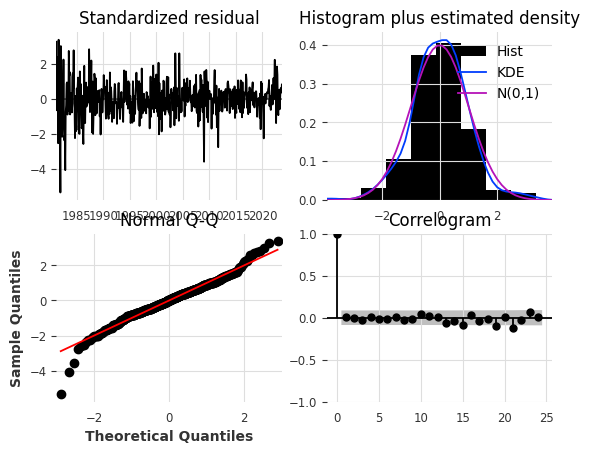

In [6]:
fig = model_fit.plot_diagnostics(lags=24)